<a href="https://colab.research.google.com/github/vivekbiragoni/Reinforcement_learning/blob/main/Reinforcement_learning_chess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[Relevent link to check up](https://github.com/KhashayarRahimi/ChessRL-Reinforcement-Learning-on-Chess/blob/main/Q-Learning.ipynb)**

In [ ]:
!apt-get install stockfish
!cp /usr/games/stockfish /content/sample_data/



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Suggested packages:
  polyglot xboard | scid
The following NEW packages will be installed:
  stockfish
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 24.8 MB of archives.
After this operation, 47.4 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 stockfish amd64 14.1-1 [24.8 MB]
Fetched 24.8 MB in 2s (10.8 MB/s)
Selecting previously unselected package stockfish.
(Reading database ... 121730 files and directories currently installed.)
Preparing to unpack .../stockfish_14.1-1_amd64.deb ...
Unpacking stockfish (14.1-1) ...
Setting up stockfish (14.1-1) ...
Processing triggers for man-db (2.10.2-1) ...


100%|██████████| 100/100 [02:22<00:00,  1.43s/it]


AgentWin: 0
StockfishWin: 100
Draw: 0
Average Reward: -0.01
Average Reward on Episodes: -0.84


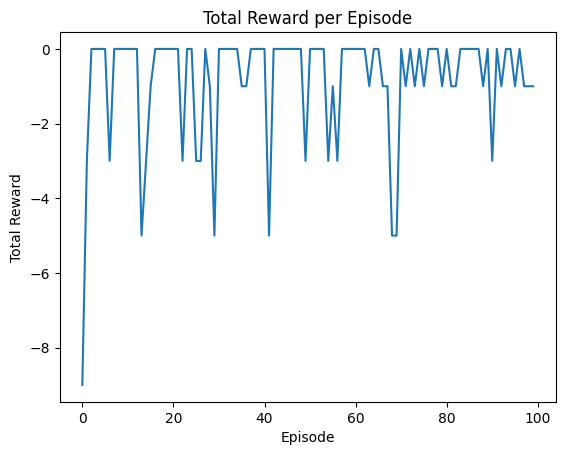

In [ ]:
!pip install python-chess stockfish tqdm

import chess
import chess.engine
import numpy as np
import random
from tqdm import tqdm
from collections import deque
import matplotlib.pyplot as plt

# Define the RL agent class
class RLAgent:
    def __init__(self, alpha=0.7, gamma=0.9, epsilon=0.5, max_q_values=100):
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.max_q_values = max_q_values
        self.q_values = deque(maxlen=max_q_values)
        self.total_reward = 0
        self.num_games = 0
        self.episode_rewards = []

        # Piece importance values
        self.piece_values = {
            chess.PAWN: 1,
            chess.KNIGHT: 3,
            chess.BISHOP: 3,
            chess.ROOK: 5,
            chess.QUEEN: 9
        }

    def get_q_value(self, state, action):
        for q_state, q_action, q_value in self.q_values:
            if q_state == state and q_action == action:
                return q_value
        return 0.0

    def update_q_value(self, state, action, next_state, reward):
        current_q = self.get_q_value(state, action)
        next_board = chess.Board(next_state)
        legal_actions = self.get_legal_actions(next_board)
        if legal_actions:
            max_q = max(self.get_q_value(next_state, a) for a in legal_actions)
        else:
            max_q = 0.0
        new_q = current_q + self.alpha * (reward + self.gamma * max_q - current_q)
        self.q_values.append((state, action, new_q))

    def get_legal_actions(self, board):
        return list(board.legal_moves)

    def choose_action(self, state):
        board = chess.Board(state)
        if random.random() < self.epsilon:
            return random.choice(self.get_legal_actions(board))
        else:
            return self.get_best_action(board)

    def get_best_action(self, board):
        legal_actions = self.get_legal_actions(board)
        best_action = legal_actions[0]
        max_q = self.get_q_value(board.fen(), best_action)
        for action in legal_actions:
            q_value = self.get_q_value(board.fen(), action)
            if q_value > max_q:
                best_action = action
                max_q = q_value
        return best_action

    def get_reward(self, captured_piece):
        if captured_piece.piece_type == chess.KING:
            return 100
        elif captured_piece.piece_type in self.piece_values:
            return self.piece_values[captured_piece.piece_type]
        else:
            return 0

    def play_game(self):
        board = chess.Board()
        # engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")
        engine = chess.engine.SimpleEngine.popen_uci("/content/sample_data/stockfish")


        while not board.is_game_over():
            if board.turn == chess.WHITE:
                state = board.fen()
                action = self.choose_action(state)
                board.push(action)
                reward = 0.0

                captured_piece = board.piece_at(action.to_square)
                if captured_piece is not None:
                    reward = self.get_reward(captured_piece)

                next_state = board.fen()
                self.update_q_value(state, action, next_state, reward)
            else:
                result = engine.play(board, chess.engine.Limit(time=0.1))
                captured_piece = board.piece_at(result.move.to_square)
                if captured_piece is not None:
                    reward = -self.get_reward(captured_piece)
                else:
                    reward = 0.0
                board.push(result.move)

        engine.quit()

        result = board.result()
        self.num_games += 1
        self.total_reward += reward
        self.episode_rewards.append(self.total_reward)

        return result

    def calculate_average_reward(self):
        if self.num_games > 0:
            return self.total_reward / self.num_games
        else:
            return 0.0


AgentWin, StockfishWin, Draw = 0, 0, 0
# Create and train the RL agent
agent = RLAgent()
episode_rewards = []

for _ in tqdm(range(100)):
    agent.total_reward = 0

    result = agent.play_game()

    if result == '1-0':
        AgentWin += 1
    elif result == '0-1':
        StockfishWin += 1
    else:
        Draw += 1

    if len(agent.q_values) > agent.max_q_values:
        agent.q_values.popleft()

    episode_rewards.append(agent.total_reward)

print('AgentWin:', AgentWin)
print('StockfishWin:', StockfishWin)
print('Draw:', Draw)

average_reward = agent.calculate_average_reward()
print('Average Reward:', average_reward)

print('Average Reward on Episodes:', np.mean(episode_rewards))

# Plot the episode rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()


In [ ]:
Stepwise_Mean = []

#EpisodeRewards = E_rewards.tolist()

for i in range(len(episode_rewards)):

    zero_to_step_i = episode_rewards[:i]

    Mean = np.mean(zero_to_step_i)

    Stepwise_Mean.append(Mean)

# Plot the episode rewards
plt.plot(Stepwise_Mean)
plt.xlabel('Episode')
plt.ylabel('Rewards Mean')
plt.title('Mean Change By Episode')
plt.show()
